In [1]:
"""
Exercise 6: Complete Classification Workflow
Neural Network Classification - Module 3

This exercise covers:
- End-to-end binary classification workflow
- End-to-end multi-class workflow
- Hyperparameter experimentation
- Model comparison and selection
- Saving and loading trained models

Learning Mottos:
- If in doubt, run the code!
- Experiment, experiment, experiment!
- Visualize, visualize, visualize!
"""


'\nExercise 6: Complete Classification Workflow\nNeural Network Classification - Module 3\n\nThis exercise covers:\n- End-to-end binary classification workflow\n- End-to-end multi-class workflow\n- Hyperparameter experimentation\n- Model comparison and selection\n- Saving and loading trained models\n\nLearning Mottos:\n- If in doubt, run the code!\n- Experiment, experiment, experiment!\n- Visualize, visualize, visualize!\n'

In [2]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import pickle
from pathlib import Path

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [3]:

# ============================================
# Part 1: Complete Binary Classification Workflow
# ============================================

print("=" * 60)
print("Part 1: Complete Binary Classification Workflow")
print("=" * 60)

# Step 1: Create data
print("\nStep 1: Creating data...")
X, y = make_circles(n_samples=1000, noise=0.03, factor=0.5, random_state=42)

# Step 2: Split data
print("Step 2: Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 3: Convert to tensors
print("Step 3: Converting to tensors...")
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).unsqueeze(1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).unsqueeze(1)

# Step 4: Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Step 4: Using device: {device}")

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Step 5: Define model
print("Step 5: Building model...")
class BinaryClassifier(nn.Module):
    def __init__(self, hidden_units=[16, 8]):
        super(BinaryClassifier, self).__init__()
        layers = []
        prev_size = 2
        for hidden_size in hidden_units:
            layers.extend([nn.Linear(prev_size, hidden_size), nn.ReLU()])
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, 1))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

model = BinaryClassifier(hidden_units=[16, 8]).to(device)

# Step 6: Define loss and optimizer
print("Step 6: Setting up loss and optimizer...")
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Step 7: Train model
print("Step 7: Training model...")
epochs = 100
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    y_logits = model(X_train)
    loss = criterion(y_logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_loss = criterion(test_logits, y_test)
        test_losses.append(test_loss.item())

    if (epoch + 1) % 20 == 0:
        print(f'  Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Step 8: Evaluate
print("Step 8: Evaluating model...")
model.eval()
with torch.inference_mode():
    test_probs = torch.sigmoid(model(X_test))
    test_preds = (test_probs > 0.5).long()

accuracy = (test_preds == y_test).float().mean()
print(f"Binary Classification Accuracy: {accuracy.item()*100:.2f}%")


Part 1: Complete Binary Classification Workflow

Step 1: Creating data...
Step 2: Splitting data...
Step 3: Converting to tensors...
Step 4: Using device: cpu
Step 5: Building model...
Step 6: Setting up loss and optimizer...
Step 7: Training model...
  Epoch [20/100], Train Loss: 0.6375, Test Loss: 0.6380
  Epoch [40/100], Train Loss: 0.4433, Test Loss: 0.4594
  Epoch [60/100], Train Loss: 0.1603, Test Loss: 0.1719
  Epoch [80/100], Train Loss: 0.0372, Test Loss: 0.0436
  Epoch [100/100], Train Loss: 0.0126, Test Loss: 0.0159
Step 8: Evaluating model...
Binary Classification Accuracy: 100.00%


In [4]:

# ============================================
# Part 2: Complete Multi-Class Workflow
# ============================================

print("\n" + "=" * 60)
print("Part 2: Complete Multi-Class Workflow")
print("=" * 60)

# Create multi-class data
print("\nCreating multi-class data...")
X_multi, y_multi = make_blobs(n_samples=1000, n_features=2, centers=4, random_state=42)

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

X_train_m = torch.FloatTensor(X_train_m)
y_train_m = torch.LongTensor(y_train_m)
X_test_m = torch.FloatTensor(X_test_m)
y_test_m = torch.LongTensor(y_test_m)

X_train_m, y_train_m = X_train_m.to(device), y_train_m.to(device)
X_test_m, y_test_m = X_test_m.to(device), y_test_m.to(device)

# Define multi-class model
class MultiClassClassifier(nn.Module):
    def __init__(self, num_classes=4, hidden_units=[16, 8]):
        super(MultiClassClassifier, self).__init__()
        layers = []
        prev_size = 2
        for hidden_size in hidden_units:
            layers.extend([nn.Linear(prev_size, hidden_size), nn.ReLU()])
            prev_size = hidden_size
        layers.append(nn.Linear(prev_size, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

model_m = MultiClassClassifier(num_classes=4, hidden_units=[16, 8]).to(device)

# Train
print("Training multi-class model...")
criterion_m = nn.CrossEntropyLoss()
optimizer_m = optim.Adam(model_m.parameters(), lr=0.01)

for epoch in range(100):
    model_m.train()
    outputs = model_m(X_train_m)
    loss = criterion_m(outputs, y_train_m)
    optimizer_m.zero_grad()
    loss.backward()
    optimizer_m.step()

    if (epoch + 1) % 20 == 0:
        print(f'  Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate
model_m.eval()
with torch.inference_mode():
    test_preds_m = torch.argmax(model_m(X_test_m), dim=1)

accuracy_m = (test_preds_m == y_test_m).float().mean()
print(f"Multi-class Accuracy: {accuracy_m.item()*100:.2f}%")



Part 2: Complete Multi-Class Workflow

Creating multi-class data...
Training multi-class model...
  Epoch [20/100], Loss: 0.6416
  Epoch [40/100], Loss: 0.0708
  Epoch [60/100], Loss: 0.0058
  Epoch [80/100], Loss: 0.0034
  Epoch [100/100], Loss: 0.0029
Multi-class Accuracy: 100.00%


In [5]:

# ============================================
# Part 3: Hyperparameter Experimentation
# ============================================

print("\n" + "=" * 60)
print("Part 3: Hyperparameter Experimentation")
print("=" * 60)

def train_and_evaluate(hidden_units, learning_rate, epochs=100):
    """Train model with given hyperparameters"""
    # Create model
    model = BinaryClassifier(hidden_units=hidden_units).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train
    for epoch in range(epochs):
        model.train()
        y_logits = model(X_train)
        loss = criterion(y_logits, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.inference_mode():
        test_preds = (torch.sigmoid(model(X_test)) > 0.5).long()
        accuracy = (test_preds == y_test).float().mean()

    return accuracy.item()

# Experiment with different configurations
configs = [
    {'hidden_units': [8], 'lr': 0.01},
    {'hidden_units': [16], 'lr': 0.01},
    {'hidden_units': [16, 8], 'lr': 0.01},
    {'hidden_units': [32, 16], 'lr': 0.001},
    {'hidden_units': [64, 32, 16], 'lr': 0.001},
]

print("\nTesting different configurations:")
results = []
for i, config in enumerate(configs):
    acc = train_and_evaluate(config['hidden_units'], config['lr'])
    results.append({**config, 'accuracy': acc})
    print(f"  Config {i+1}: hidden={config['hidden_units']}, lr={config['lr']}, Accuracy: {acc*100:.2f}%")

# Find best configuration
best_config = max(results, key=lambda x: x['accuracy'])
print(f"\nBest configuration: {best_config}")



Part 3: Hyperparameter Experimentation

Testing different configurations:
  Config 1: hidden=[8], lr=0.01, Accuracy: 95.00%
  Config 2: hidden=[16], lr=0.01, Accuracy: 100.00%
  Config 3: hidden=[16, 8], lr=0.01, Accuracy: 100.00%
  Config 4: hidden=[32, 16], lr=0.001, Accuracy: 100.00%
  Config 5: hidden=[64, 32, 16], lr=0.001, Accuracy: 100.00%

Best configuration: {'hidden_units': [16], 'lr': 0.01, 'accuracy': 1.0}


In [6]:

# ============================================
# Part 4: Model Comparison
# ============================================

print("\n" + "=" * 60)
print("Part 4: Model Comparison")
print("=" * 60)

# Train multiple models
models = {
    'Linear': BinaryClassifier(hidden_units=[]),
    'Small': BinaryClassifier(hidden_units=[8]),
    'Medium': BinaryClassifier(hidden_units=[16, 8]),
    'Large': BinaryClassifier(hidden_units=[32, 16]),
}

print("\nComparing different model sizes:")
comparison_results = {}

for name, model_comp in models.items():
    model_comp = model_comp.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_comp.parameters(), lr=0.01)

    # Train
    for epoch in range(100):
        model_comp.train()
        y_logits = model_comp(X_train)
        loss = criterion(y_logits, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate
    model_comp.eval()
    with torch.inference_mode():
        test_preds = (torch.sigmoid(model_comp(X_test)) > 0.5).long()
        accuracy = (test_preds == y_test).float().mean()
        params = sum(p.numel() for p in model_comp.parameters())

    comparison_results[name] = {
        'accuracy': accuracy.item(),
        'parameters': params
    }
    print(f"  {name:8s}: Accuracy={accuracy.item()*100:5.2f}%, Parameters={params:,}")



Part 4: Model Comparison

Comparing different model sizes:
  Linear  : Accuracy=46.00%, Parameters=3
  Small   : Accuracy=75.00%, Parameters=33
  Medium  : Accuracy=100.00%, Parameters=193
  Large   : Accuracy=100.00%, Parameters=641


In [7]:

# ============================================
# Part 5: Saving and Loading Models
# ============================================

print("\n" + "=" * 60)
print("Part 5: Saving and Loading Models")
print("=" * 60)

# Create directory for saving models
model_dir = Path('saved_models')
model_dir.mkdir(exist_ok=True)

# Save model state dict
model_path = model_dir / 'binary_classifier.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to: {model_path}")

# Load model
loaded_model = BinaryClassifier(hidden_units=[16, 8])
loaded_model.load_state_dict(torch.load(model_path))
loaded_model = loaded_model.to(device)
loaded_model.eval()
print("Model loaded successfully!")

# Verify loaded model works
with torch.inference_mode():
    test_preds_loaded = (torch.sigmoid(loaded_model(X_test)) > 0.5).long()
    accuracy_loaded = (test_preds_loaded == y_test).float().mean()
print(f"Loaded model accuracy: {accuracy_loaded.item()*100:.2f}%")

# Save complete model (including architecture)
complete_model_path = model_dir / 'binary_classifier_complete.pth'
torch.save(model, complete_model_path)
print(f"Complete model saved to: {complete_model_path}")

# Load complete model
loaded_complete = torch.load(complete_model_path)
loaded_complete.eval()
print("Complete model loaded successfully!")



Part 5: Saving and Loading Models
Model saved to: saved_models/binary_classifier.pth
Model loaded successfully!
Loaded model accuracy: 100.00%
Complete model saved to: saved_models/binary_classifier_complete.pth
Complete model loaded successfully!


In [8]:

# ============================================
# Part 6: Model Inference Function
# ============================================

print("\n" + "=" * 60)
print("Part 6: Model Inference Function")
print("=" * 60)

def predict(model, X_new, device='cpu'):
    """Make predictions on new data"""
    model.eval()
    model = model.to(device)

    # Convert to tensor if needed
    if not isinstance(X_new, torch.Tensor):
        X_new = torch.FloatTensor(X_new)

    X_new = X_new.to(device)

    # Make prediction
    with torch.inference_mode():
        logits = model(X_new)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long()

    return {
        'logits': logits.cpu(),
        'probabilities': probs.cpu(),
        'predictions': preds.cpu()
    }

# Test inference function
X_new = torch.randn(5, 2)
results = predict(model, X_new, device)

print("\nPredictions for 5 new samples:")
for i in range(5):
    print(f"  Sample {i+1}:")
    print(f"    Input: {X_new[i].numpy()}")
    print(f"    Probability: {results['probabilities'][i].item():.4f}")
    print(f"    Predicted class: {results['predictions'][i].item()}")



Part 6: Model Inference Function

Predictions for 5 new samples:
  Sample 1:
    Input: [0.98332787 0.24284378]
    Probability: 0.0020
    Predicted class: 0
  Sample 2:
    Input: [-0.4691859   0.12883222]
    Probability: 0.9871
    Predicted class: 1
  Sample 3:
    Input: [0.35263926 0.2444982 ]
    Probability: 0.9983
    Predicted class: 1
  Sample 4:
    Input: [-0.13457076 -0.34153143]
    Probability: 0.9995
    Predicted class: 1
  Sample 5:
    Input: [ 0.6820614  -0.24444687]
    Probability: 0.5772
    Predicted class: 1


In [9]:

# ============================================
# Part 7: Complete Training Class
# ============================================

print("\n" + "=" * 60)
print("Part 7: Complete Training Class")
print("=" * 60)

class ClassificationTrainer:
    """Complete training pipeline for classification"""

    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.history = {'train_loss': [], 'test_loss': []}

    def train(self, X_train, y_train, X_test, y_test,
              epochs=100, lr=0.01):
        """Train the model"""
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        for epoch in range(epochs):
            # Training
            self.model.train()
            y_logits = self.model(X_train)
            loss = criterion(y_logits, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Testing
            self.model.eval()
            with torch.inference_mode():
                test_logits = self.model(X_test)
                test_loss = criterion(test_logits, y_test)

            self.history['train_loss'].append(loss.item())
            self.history['test_loss'].append(test_loss.item())

            if (epoch + 1) % 20 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

    def evaluate(self, X_test, y_test):
        """Evaluate the model"""
        self.model.eval()
        with torch.inference_mode():
            test_probs = torch.sigmoid(self.model(X_test))
            test_preds = (test_probs > 0.5).long()
            accuracy = (test_preds == y_test).float().mean()

        return accuracy.item()

    def save(self, path):
        """Save the model"""
        torch.save(self.model.state_dict(), path)
        print(f"Model saved to: {path}")

    def load(self, path):
        """Load the model"""
        self.model.load_state_dict(torch.load(path))
        print(f"Model loaded from: {path}")

# Use the trainer
print("\nUsing ClassificationTrainer:")
model_trainer = BinaryClassifier(hidden_units=[16, 8])
trainer = ClassificationTrainer(model_trainer, device=device)
trainer.train(X_train, y_train, X_test, y_test, epochs=100, lr=0.01)
accuracy_trainer = trainer.evaluate(X_test, y_test)
print(f"Final accuracy: {accuracy_trainer*100:.2f}%")

# Save the trained model
trainer.save(model_dir / 'trained_classifier.pth')



Part 7: Complete Training Class

Using ClassificationTrainer:
Epoch [20/100], Train Loss: 0.6290, Test Loss: 0.6313
Epoch [40/100], Train Loss: 0.4362, Test Loss: 0.4347
Epoch [60/100], Train Loss: 0.2359, Test Loss: 0.2351
Epoch [80/100], Train Loss: 0.1710, Test Loss: 0.1710
Epoch [100/100], Train Loss: 0.1374, Test Loss: 0.1376
Final accuracy: 100.00%
Model saved to: saved_models/trained_classifier.pth



Part 8: Training Curves Visualization


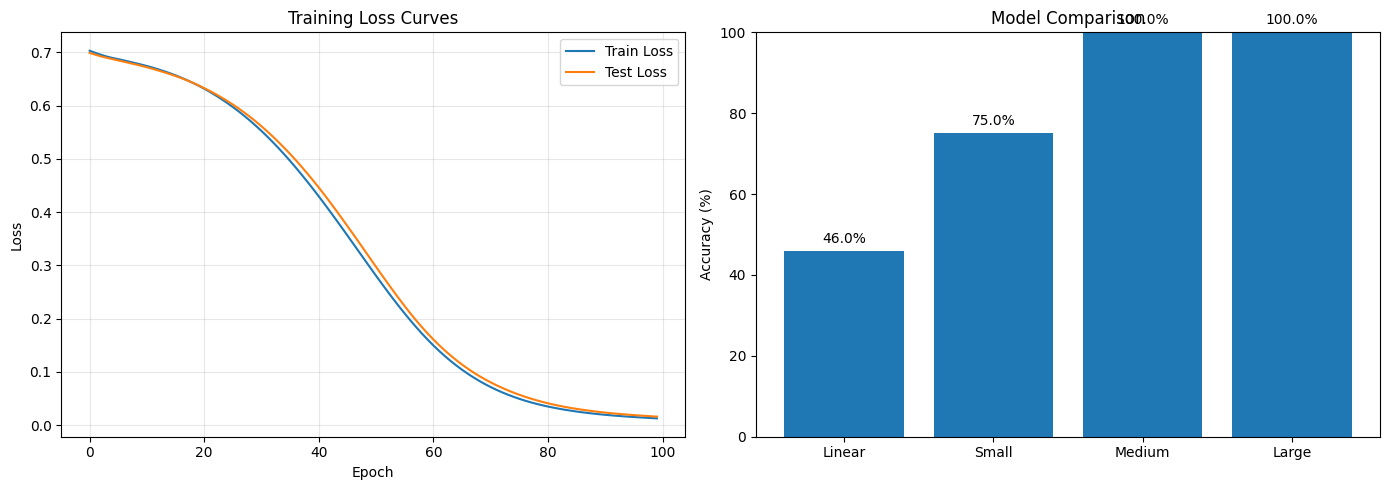

In [10]:

# ============================================
# Part 8: Training Curves Visualization
# ============================================

print("\n" + "=" * 60)
print("Part 8: Training Curves Visualization")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(test_losses, label='Test Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Model comparison
names = list(comparison_results.keys())
accuracies = [comparison_results[name]['accuracy'] * 100 for name in names]
axes[1].bar(names, accuracies)
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Model Comparison')
axes[1].set_ylim(0, 100)
for i, v in enumerate(accuracies):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center')

plt.tight_layout()
plt.show()


In [11]:

# ============================================
# Exercises
# ============================================

print("\n" + "=" * 60)
print("Exercises")
print("=" * 60)



Exercises


In [12]:

# Exercise 1: Design your own experiment
print("\nExercise 1: Design your own experiment")
print("Create and test your own model configuration:")
print("  - Try different architectures")
print("  - Try different learning rates")
print("  - Try different numbers of epochs")
print("Tip: Use the ClassificationTrainer class")

def run_experiment(hidden_units, lr, epochs):
    # Create a fresh model for each run
    model = BinaryClassifier(hidden_units=hidden_units)
    trainer = ClassificationTrainer(model, device=device)
    trainer.train(X_train, y_train, X_test, y_test, epochs=epochs, lr=lr)
    acc = trainer.evaluate(X_test, y_test)
    return acc

experiments = [
    {"name": "Shallow_fast",   "hidden_units": [8],         "lr": 0.05,  "epochs": 50},
    {"name": "Medium_default", "hidden_units": [16, 8],     "lr": 0.01,  "epochs": 100},
    {"name": "Wide_slow",      "hidden_units": [64, 32, 8], "lr": 0.001, "epochs": 150},
]

results = []

for exp in experiments:
    print(f"Running {exp['name']} "
          f"(hidden={exp['hidden_units']}, lr={exp['lr']}, epochs={exp['epochs']})")
    acc = run_experiment(exp["hidden_units"], exp["lr"], exp["epochs"])
    results.append({**exp, "accuracy": acc})
    print(f"  -> Accuracy: {acc*100:.2f}%\n")

print("\nSummary:")
for r in results:
    print(f"{r['name']:15s} | hidden={r['hidden_units']} | "
          f"lr={r['lr']:>6} | epochs={r['epochs']:>3} | "
          f"accuracy={r['accuracy']*100:5.2f}%")



Exercise 1: Design your own experiment
Create and test your own model configuration:
  - Try different architectures
  - Try different learning rates
  - Try different numbers of epochs
Tip: Use the ClassificationTrainer class
Running Shallow_fast (hidden=[8], lr=0.05, epochs=50)
Epoch [20/50], Train Loss: 0.4167, Test Loss: 0.4256
Epoch [40/50], Train Loss: 0.0979, Test Loss: 0.0973
  -> Accuracy: 100.00%

Running Medium_default (hidden=[16, 8], lr=0.01, epochs=100)
Epoch [20/100], Train Loss: 0.5177, Test Loss: 0.5188
Epoch [40/100], Train Loss: 0.1529, Test Loss: 0.1606
Epoch [60/100], Train Loss: 0.0204, Test Loss: 0.0241
Epoch [80/100], Train Loss: 0.0062, Test Loss: 0.0083
Epoch [100/100], Train Loss: 0.0036, Test Loss: 0.0051
  -> Accuracy: 100.00%

Running Wide_slow (hidden=[64, 32, 8], lr=0.001, epochs=150)
Epoch [20/150], Train Loss: 0.6794, Test Loss: 0.6790
Epoch [40/150], Train Loss: 0.6540, Test Loss: 0.6530
Epoch [60/150], Train Loss: 0.5996, Test Loss: 0.5972
Epoch [80

In [13]:

# Exercise 2: Compare on different datasets
print("\nExercise 2: Compare on different datasets")
print("Test models on different datasets:")
print("  - make_circles with different noise levels")
print("  - make_blobs with different number of classes")
print("Tip: Modify the data creation code")

# Binary: make_circles with different noise levels
def run_circles_experiment(noise, n_samples=1000, epochs=100, lr=0.01, hidden_units=[16, 8]):
    # create data
    X, y = make_circles(
        n_samples=n_samples,
        noise=noise,
        factor=0.5,
        random_state=42,
    )

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_test  = torch.FloatTensor(X_test).to(device)
    y_test  = torch.FloatTensor(y_test).unsqueeze(1).to(device)

    # 4) use ClassificationTrainer (binary)
    model = BinaryClassifier(hidden_units=hidden_units)
    trainer = ClassificationTrainer(model, device=device)
    trainer.train(X_train, y_train, X_test, y_test, epochs=epochs, lr=lr)
    acc = trainer.evaluate(X_test, y_test)
    return acc

noises = [0.02, 0.05, 0.15]

print("Binary classification on make_circles with different noise:")
circles_results = []
for n in noises:
    print(f"\nNoise = {n}")
    acc = run_circles_experiment(noise=n, epochs=80, lr=0.01, hidden_units=[16, 8])
    circles_results.append((n, acc))
    print(f"Accuracy: {acc*100:.2f}%")

# Multi-class: make_blobs with different number of classes

def run_blobs_experiment(n_classes, n_samples=1000, epochs=100, lr=0.01, hidden_units=[16, 8]):
    # create data
    X, y = make_blobs(
        n_samples=n_samples,
        n_features=2,
        centers=n_classes,
        random_state=42,
    )

    # train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # tensors
    X_train = torch.FloatTensor(X_train).to(device)
    y_train = torch.LongTensor(y_train).to(device)
    X_test  = torch.FloatTensor(X_test).to(device)
    y_test  = torch.LongTensor(y_test).to(device)

    # multi-class model + standard training loop
    model = MultiClassClassifier(num_classes=n_classes, hidden_units=hidden_units).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        logits = model(X_train)
        loss = criterion(logits, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # evaluate
    model.eval()
    with torch.inference_mode():
        preds = torch.argmax(model(X_test), dim=1)
        acc = (preds == y_test).float().mean().item()

    return acc

classes_list = [3, 4, 6]

print("\nMulti-class classification on make_blobs with different numbers of classes:")
blobs_results = []
for c in classes_list:
    print(f"\nNumber of classes = {c}")
    acc = run_blobs_experiment(n_classes=c, epochs=80, lr=0.01, hidden_units=[16, 8])
    blobs_results.append((c, acc))
    print(f"Accuracy: {acc*100:.2f}%")

print("\n\n===== Summary =====")
print("make_circles (noise vs accuracy):")
for n, acc in circles_results:
    print(f"  noise={n:.2f} -> accuracy={acc*100:.2f}%")

print("\nmake_blobs (num_classes vs accuracy):")
for c, acc in blobs_results:
    print(f"  classes={c} -> accuracy={acc*100:.2f}%")


Exercise 2: Compare on different datasets
Test models on different datasets:
  - make_circles with different noise levels
  - make_blobs with different number of classes
Tip: Modify the data creation code
Binary classification on make_circles with different noise:

Noise = 0.02
Epoch [20/80], Train Loss: 0.6164, Test Loss: 0.6108
Epoch [40/80], Train Loss: 0.3088, Test Loss: 0.2993
Epoch [60/80], Train Loss: 0.0529, Test Loss: 0.0531
Epoch [80/80], Train Loss: 0.0098, Test Loss: 0.0108
Accuracy: 100.00%

Noise = 0.05
Epoch [20/80], Train Loss: 0.6063, Test Loss: 0.6096
Epoch [40/80], Train Loss: 0.3068, Test Loss: 0.3049
Epoch [60/80], Train Loss: 0.0501, Test Loss: 0.0601
Epoch [80/80], Train Loss: 0.0106, Test Loss: 0.0149
Accuracy: 100.00%

Noise = 0.15
Epoch [20/80], Train Loss: 0.6325, Test Loss: 0.6446
Epoch [40/80], Train Loss: 0.3938, Test Loss: 0.4517
Epoch [60/80], Train Loss: 0.1651, Test Loss: 0.2738
Epoch [80/80], Train Loss: 0.1120, Test Loss: 0.2536
Accuracy: 89.00%

Mu

In [ ]:

# Exercise 3: Implement early stopping
print("\nExercise 3: Implement early stopping")
print("Stop training when test loss stops improving:")
print("  - Track test loss each epoch")
print("  - Stop if no improvement for N epochs")
print("Tip: Add patience parameter to training loop")

class EarlyStoppingTrainer(ClassificationTrainer):
    def train(self, X_train, y_train, X_test, y_test,
              epochs=100, lr=0.01, patience=10, min_delta=1e-4):
        """Train with early stopping based on test loss."""
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=lr)

        best_loss = float('inf')
        best_state = None
        patience_counter = 0

        for epoch in range(epochs):
            # training
            self.model.train()
            y_logits = self.model(X_train)
            loss = criterion(y_logits, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # validation / test
            self.model.eval()
            with torch.inference_mode():
                test_logits = self.model(X_test)
                test_loss = criterion(test_logits, y_test)

            self.history['train_loss'].append(loss.item())
            self.history['test_loss'].append(test_loss.item())

            # early stopping logic
            if test_loss.item() + min_delta < best_loss:
                best_loss = test_loss.item()
                best_state = self.model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

            if (epoch + 1) % 20 == 0:
                print(f"Epoch [{epoch+1}/{epochs}], "
                      f"Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1} "
                      f"(best test loss = {best_loss:.4f})")
                break

        if best_state is not None:
            self.model.load_state_dict(best_state)


# use EarlyStoppingTrainer on the existing binary data
early_model = BinaryClassifier(hidden_units=[16, 8])
early_trainer = EarlyStoppingTrainer(early_model, device=device)
early_trainer.train(X_train, y_train, X_test, y_test,
                    epochs=200, lr=0.01, patience=15)
early_acc = early_trainer.evaluate(X_test, y_test)
print(f"Early-stopping accuracy: {early_acc*100:.2f}%")


Exercise 3: Implement early stopping
Stop training when test loss stops improving:
  - Track test loss each epoch
  - Stop if no improvement for N epochs
Tip: Add patience parameter to training loop
Epoch [20/200], Train Loss: 0.5863, Test Loss: 0.5784
Epoch [40/200], Train Loss: 0.2635, Test Loss: 0.2521
Epoch [60/200], Train Loss: 0.0431, Test Loss: 0.0460
Epoch [80/200], Train Loss: 0.0097, Test Loss: 0.0117
Epoch [100/200], Train Loss: 0.0045, Test Loss: 0.0058
Epoch [120/200], Train Loss: 0.0029, Test Loss: 0.0039
Epoch [140/200], Train Loss: 0.0021, Test Loss: 0.0029
Epoch [160/200], Train Loss: 0.0016, Test Loss: 0.0023
Epoch [180/200], Train Loss: 0.0013, Test Loss: 0.0018
Epoch [200/200], Train Loss: 0.0010, Test Loss: 0.0015
Early-stopping accuracy: 100.00%


In [ ]:

# Exercise 4: Create model comparison report
print("\nExercise 4: Create model comparison report")
print("Compare models and create a report:")
print("  - Test accuracy")
print("  - Number of parameters")
print("  - Training time")
print("Tip: Track training time with time.time()")

import time 

models_to_compare = {
    'Linear': BinaryClassifier(hidden_units=[]),
    'Small':  BinaryClassifier(hidden_units=[8]),
    'Medium': BinaryClassifier(hidden_units=[16, 8]),
    'Large':  BinaryClassifier(hidden_units=[32, 16]),
}

comparison_report = []

for name, model_comp in models_to_compare.items():
    model_comp = model_comp.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model_comp.parameters(), lr=0.01)

    start_time = time.time()

    # simple fixed-epoch training
    for epoch in range(80):
        model_comp.train()
        y_logits = model_comp(X_train)
        loss = criterion(y_logits, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    elapsed = time.time() - start_time

    # evaluate
    model_comp.eval()
    with torch.inference_mode():
        test_preds = (torch.sigmoid(model_comp(X_test)) > 0.5).long()
        accuracy = (test_preds == y_test).float().mean().item()

    params = sum(p.numel() for p in model_comp.parameters())

    comparison_report.append({
        'name': name,
        'accuracy': accuracy,
        'parameters': params,
        'training_time_sec': elapsed,
    })

print("\nModel comparison report:")
print(f"{'Model':10s} | {'Params':>10s} | {'Accuracy':>9s} | {'Time (s)':>9s}")
print("-" * 50)
for row in comparison_report:
    print(f"{row['name']:10s} | "
          f"{row['parameters']:10d} | "
          f"{row['accuracy']*100:8.2f}% | "
          f"{row['training_time_sec']:8.2f}")


Exercise 4: Create model comparison report
Compare models and create a report:
  - Test accuracy
  - Number of parameters
  - Training time
Tip: Track training time with time.time()

Model comparison report:
Model      |     Params |  Accuracy |  Time (s)
--------------------------------------------------
Linear     |          3 |    61.00% |     0.04
Small      |         33 |    91.50% |     0.05
Medium     |        193 |   100.00% |     0.06
Large      |        641 |   100.00% |     0.07


In [ ]:

# Exercise 5: Save/load with metadata
print("\nExercise 5: Save/load with metadata")
print("Save model with additional information:")
print("  - Hyperparameters")
print("  - Training metrics")
print("  - Date/time")
print("Tip: Use pickle or create a dictionary to save")

from datetime import datetime  # if not already imported

print("\nExercise 5: Save/load with metadata")

# reuse the early-stopping trainer/model from Exercise 3.
# can run a fresh trainer here.
metadata_path = model_dir / "binary_classifier_with_metadata.pkl"

metadata = {
    "model_state_path": str(model_dir / "trained_classifier_with_metadata.pth"),
    "hyperparameters": {
        "hidden_units": [16, 8],
        "learning_rate": 0.01,
        "patience": 15,
        "epochs_run": len(early_trainer.history['train_loss']),
    },
    "metrics": {
        "final_accuracy": early_acc,
        "train_loss_history": early_trainer.history['train_loss'],
        "test_loss_history": early_trainer.history['test_loss'],
    },
    "created_at": datetime.now().isoformat(),
}

# save model weights
model_state_path = Path(metadata["model_state_path"])
torch.save(early_model.state_dict(), model_state_path)

# save metadata
with open(metadata_path, "wb") as f:
    pickle.dump(metadata, f)

print(f"Saved model state to: {model_state_path}")
print(f"Saved metadata to:   {metadata_path}")

# load metadata back
with open(metadata_path, "rb") as f:
    loaded_metadata = pickle.load(f)

print("\nLoaded metadata:")
for k, v in loaded_metadata.items():
    if k == "metrics":
        print(f"{k}:")
        print(f"  final_accuracy: {v['final_accuracy']*100:.2f}%")
        print(f"  train_loss_history length: {len(v['train_loss_history'])}")
        print(f"  test_loss_history length:  {len(v['test_loss_history'])}")
    else:
        print(f"{k}: {v}")

# optionally reconstruct a model from the saved state:
reloaded_model = BinaryClassifier(hidden_units=loaded_metadata["hyperparameters"]["hidden_units"])
reloaded_model.load_state_dict(torch.load(model_state_path))
reloaded_model = reloaded_model.to(device)
reloaded_model.eval()

with torch.inference_mode():
    preds_reloaded = (torch.sigmoid(reloaded_model(X_test)) > 0.5).long()
    acc_reloaded = (preds_reloaded == y_test).float().mean().item()

print(f"\nReloaded model accuracy: {acc_reloaded*100:.2f}%")


Exercise 5: Save/load with metadata
Save model with additional information:
  - Hyperparameters
  - Training metrics
  - Date/time
Tip: Use pickle or create a dictionary to save

Exercise 5: Save/load with metadata
Saved model state to: saved_models/trained_classifier_with_metadata.pth
Saved metadata to:   saved_models/binary_classifier_with_metadata.pkl

Loaded metadata:
model_state_path: saved_models/trained_classifier_with_metadata.pth
hyperparameters: {'hidden_units': [16, 8], 'learning_rate': 0.01, 'patience': 15, 'epochs_run': 200}
metrics:
  final_accuracy: 100.00%
  train_loss_history length: 200
  test_loss_history length:  200
created_at: 2026-02-11T23:59:00.679888

Reloaded model accuracy: 100.00%


In [17]:

print("\n" + "=" * 60)
print("Exercise 6 Complete!")
print("Remember: If in doubt, run the code!")
print("Remember: Experiment, experiment, experiment!")
print("Remember: Visualize, visualize, visualize!")
print("=" * 60)



Exercise 6 Complete!
Remember: If in doubt, run the code!
Remember: Experiment, experiment, experiment!
Remember: Visualize, visualize, visualize!
